In [15]:
from IPython.core.display import display, HTML

### Widen notebook to fit browser window
display(HTML("<style>.container { width:100% !important; }</style>"))

In [16]:
from os import listdir
from os.path import isfile, join

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog

from file_utils import get_img_filenames
from configuration import dict_config_params

In [17]:
def transform_colorspace(image, cspace):
    # apply color conversion if other than 'RGB'
    # cspace = dict_config_params['color_space']
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(image)  
        
    return feature_image

In [18]:
### Gradient features ###

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)        
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        hog_image = None
        
    #features = features.ravel()
    return features, hog_image
    
    
def extract_hog_features(image, hog_feat=True, visualize=False):
    
    if hog_feat is not True:
        return [], None
    
    if dict_config_params['use_gray_img'] is True:
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        feature_image = transform_colorspace(image, dict_config_params['hog_cspace'])
    
    # Parameters
    hog_channel = dict_config_params['hog_channel']
    n_orientations = dict_config_params['hog_n_orientations']
    pixels_per_cell = dict_config_params['hog_pixels_per_cell']
    cells_per_block = dict_config_params['hog_cells_per_block']
    
    hog_features = []
    single_channel_img = len(feature_image.shape)==2
    
    if hog_feat == True:     
        if single_channel_img is True:
            hog_features, hog_image = get_hog_features(feature_image, 
                                                       n_orientations, 
                                                       pixels_per_cell, cells_per_block, 
                                                       vis=visualize, feature_vec=False)
        
        elif hog_channel == 'ALL':            
            for channel in range(feature_image.shape[2]):
                features, hog_image = get_hog_features(feature_image[:,:,channel], 
                                                       n_orientations, 
                                                       pixels_per_cell, cells_per_block, 
                                                       vis=visualize, feature_vec=False)
                hog_features.append(features)                
        else:
            hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], 
                                                       n_orientations, 
                                                       pixels_per_cell, cells_per_block, 
                                                       vis=visualize, feature_vec=False)
        
    return hog_features, hog_image

In [19]:
### Color features ###

# Define a function to compute binned color features  
def bin_spatial(img):
        
    size = dict_config_params['color_spatial_size']
    
    features = cv2.resize(img, size).ravel() 
    return features


# Define a function to compute color histogram features  
def color_hist(img):
    nbins = dict_config_params['color_hist_bins']
    bins_range = dict_config_params['color_hist_range']
    
    # Compute the histograms of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features


def extract_color_features(image, spatial_feat=True, hist_feat=True):

    color_features = []
    
    if spatial_feat is not True and hist_feat is not True:
        return color_features
    
    feature_image = transform_colorspace(image, dict_config_params['color_cspace'])
    
    # Get spatial color features
    if spatial_feat is True:
        spatial_features = bin_spatial(feature_image)
        color_features.append(spatial_features)
    
    # Get color histogram features
    if hist_feat is True:
        hist_features = color_hist(feature_image)
        color_features.append(hist_features)
    
    # Concatenate spatial and histogram features
    color_features = np.concatenate(color_features)
        
    # Return list of feature vectors
    return color_features

In [20]:
def extract_features(image, verbose=True, 
                     hog_feat=True, spatial_feat=True, hist_feat=True):   

    features = []
    
    # --- Extract HOG features ---    
    hog_features, hog_image = extract_hog_features(image, 
                                                   hog_feat=hog_feat, visualize=verbose)    
    features.append(np.ravel(hog_features))    

    # --- Extract Color features ---
    color_features = extract_color_features(image, 
                                            spatial_feat=spatial_feat, hist_feat=hist_feat)    
    features.append(color_features)
    
    if verbose is True:
        print()
        print("len(hog_features): {}".format(len(hog_features)))
        print("len(color_features): {}".format(len(color_features)))
        
        if hog_image is not None:
            # Plot 
            fig = plt.figure()
            plt.subplot(121)
            plt.imshow(image, cmap='gray')
            plt.title('Example Car Image')
            plt.subplot(122)
            plt.imshow(hog_image, cmap='gray')
            plt.title('HOG Visualization')
    
    return np.concatenate(features)

listdir(imgs_dir_cars): ['GTI_MiddleClose', 'KITTI_extracted', 'GTI_Right', 'GTI_Left', 'GTI_Far']
listdir(imgs_dir_notcars): ['Extras', 'GTI']

len(img_filenames_cars): 8792
len(img_filenames_notcars): 8968

len(hog_features): 1764
len(color_features): 3168

len(img_features): 4932


/home.net/rh17dur/miniconda3/envs/carnd-term1-gpu/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


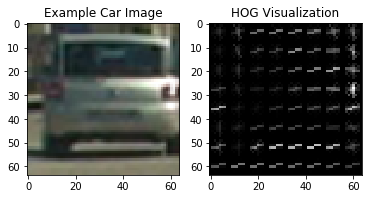

In [21]:
if __name__== "__main__":
        
    img_filenames_cars, img_filenames_notcars = get_img_filenames()
    
    # Take a random image
    ind = np.random.randint(0, len(img_filenames_cars))
    image = mpimg.imread(img_filenames_cars[ind])
    
    hog_feat = dict_config_params['use_hog_feat']
    spatial_feat = dict_config_params['use_spatial_feat']
    hist_feat = dict_config_params['use_hist_feat']
        
    img_features = extract_features(image, verbose=True, 
                                hog_feat=hog_feat, spatial_feat=spatial_feat, hist_feat=hist_feat)
    
    print()
    print("len(img_features): {}".format(len(img_features)))
        
    plt.show()